In [26]:
import pandas as pd
import numpy as np
import pytensor.tensor as pt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from imblearn.under_sampling import RandomUnderSampler
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

In [7]:
!pip install ucimlrepo

In [9]:
dataset = fetch_ucirepo(id=350)
X = dataset.data.features

y = dataset.data.targets
y = y.iloc[:, 0]

In [14]:
# Define feature groups
categorical_features = {'X2': 'SEX','X3': 'EDUCATION','X4': 'MARRIAGE'}

numerical_features = ['X1', 'X5']  # LIMIT_BAL, AGE
payment_history = [f'X{i}' for i in range(6, 12)]
bill_amounts = [f'X{i}' for i in range(12, 18)]
payment_amounts = [f'X{i}' for i in range(18, 24)]
all_numerical = numerical_features + bill_amounts + payment_amounts

In [10]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTrain/Test split sizes:")
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


Train/Test split sizes:
Train set: (24000, 23), Test set: (6000, 23)


In [11]:
# Feature selection using Mutual Information
threshold = 0.01

mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
scores_df = pd.DataFrame({
    'feature': X_train.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

selected_features = scores_df[scores_df['mi_score'] > threshold]['feature'].tolist()
print("\nFeature Selection Scores:")
print(scores_df)




Feature Selection Scores:
   feature  mi_score
5       X6  0.078625
6       X7  0.050079
7       X8  0.037311
8       X9  0.033667
9      X10  0.030242
17     X18  0.026276
19     X20  0.022004
10     X11  0.020371
18     X19  0.016327
0       X1  0.016027
21     X22  0.015859
20     X21  0.014507
22     X23  0.008993
11     X12  0.008301
12     X13  0.006647
14     X15  0.006605
15     X16  0.006411
2       X3  0.005619
13     X14  0.003805
3       X4  0.002592
16     X17  0.002401
4       X5  0.001052
1       X2  0.000304


In [12]:
print(f"top {len(selected_features)} features selected")

top 12 features selected


In [15]:
# Balance the dataset using undersampling
rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train[selected_features], y_train)

# Convert to DataFrame and prepare for modeling
X_train_processed = pd.DataFrame(X_train_balanced, columns=selected_features)
X_test_processed = X_test[selected_features].copy()

# Scale the selected numerical features
numerical_selected = [feat for feat in all_numerical if feat in selected_features]
scaler = StandardScaler()
X_train_processed[numerical_selected] = scaler.fit_transform(X_train_processed[numerical_selected])
X_test_processed[numerical_selected] = scaler.transform(X_test_processed[numerical_selected])

print("\nProcessed dataset shapes:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")
print(f"y_train_balanced: {y_train_balanced.shape}")


Processed dataset shapes:
X_train_processed: (10646, 12)
X_test_processed: (6000, 12)
y_train_balanced: (10646,)


In [16]:
# Define weighted logp function for class imbalance
def weighted_logp(value, logit_p, w0, w1):
    p = pt.sigmoid(logit_p)
    return pt.switch(value,
                    w1 * pt.log(p),      # class 1
                    w0 * pt.log1p(-p))   # class 0

In [30]:
# Prepare data for PyMC model
num_samples = 10000
X1 = X_train_processed.values
X2 = X_test_processed.values
y1 = y_train_balanced
y2 = y_test.values

# Calculate class weights
neg_count = (y1 == 0).sum()
pos_count = (y1 == 1).sum()
w0 = pos_count / neg_count
w1 = 1.0


In [ ]:
# Build and run PyMC model
print("\nRunning MCMC sampling...")
with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sigma=5)
    betas = pm.Normal('betas', mu=0, sigma=2, shape=X1.shape[1])
    mu = intercept + pm.math.dot(X1, betas)

    y_obs = pm.CustomDist('y_obs',
                         mu,
                         w0,
                         w1,
                         logp=weighted_logp,
                         observed=y1)

    weighted_trace = pm.sample(num_samples, tune=2000, target_accept=.99, chains=2)


Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:05:49

In [ ]:
# Calculate feature importance
betas_mean = weighted_trace.posterior['betas'].mean(dim=('chain', 'draw')).values
betas_std = weighted_trace.posterior['betas'].std(dim=('chain', 'draw')).values

importance_df = pd.DataFrame({
    'feature': selected_features,
    'coefficient_mean': betas_mean,
    'coefficient_std': betas_std,
    'abs_importance': np.abs(betas_mean)
}).sort_values('abs_importance', ascending=False)


In [ ]:
# Make predictions
intercept_mean = weighted_trace.posterior['intercept'].mean(dim=('chain', 'draw')).item()
logits = intercept_mean + np.dot(X2, betas_mean)
y_pred_proba = 1 / (1 + np.exp(-logits))
y_pred = (y_pred_proba > 0.5).astype(int)


In [ ]:
# Evaluate model
results = {
'confusion_matrix': confusion_matrix(y_test, y_pred),
'classification_report': classification_report(y_test, y_pred),
'feature_importance': importance_df,
'trace': weighted_trace,
'selected_features': selected_features
}

In [23]:
# Print model performance metrics
print("\nModel Performance:")
print("\nConfusion Matrix:")
print(confusion_matrix(y2, y_pred))
print("\nClassification Report:")
print(classification_report(y2, y_pred))
print(f"\nTop {len(selected_features)} Most Important Features:")
print(importance_df)


Model Performance:

Confusion Matrix:
[[3213 1474]
 [ 431  882]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      4687
           1       0.37      0.67      0.48      1313

    accuracy                           0.68      6000
   macro avg       0.63      0.68      0.63      6000
weighted avg       0.77      0.68      0.71      6000


Top 12 Most Important Features:
   feature  coefficient_mean  coefficient_std  abs_importance
0       X6          0.495356         0.023748        0.495356
8      X19         -0.237286         0.052864        0.237286
5      X18         -0.107473         0.029206        0.107473
9       X1         -0.092770         0.024409        0.092770
1       X7          0.086218         0.028103        0.086218
2       X8          0.069234         0.030839        0.069234
11     X21         -0.064543         0.026936        0.064543
6      X20         -0.058221         0.027309        0

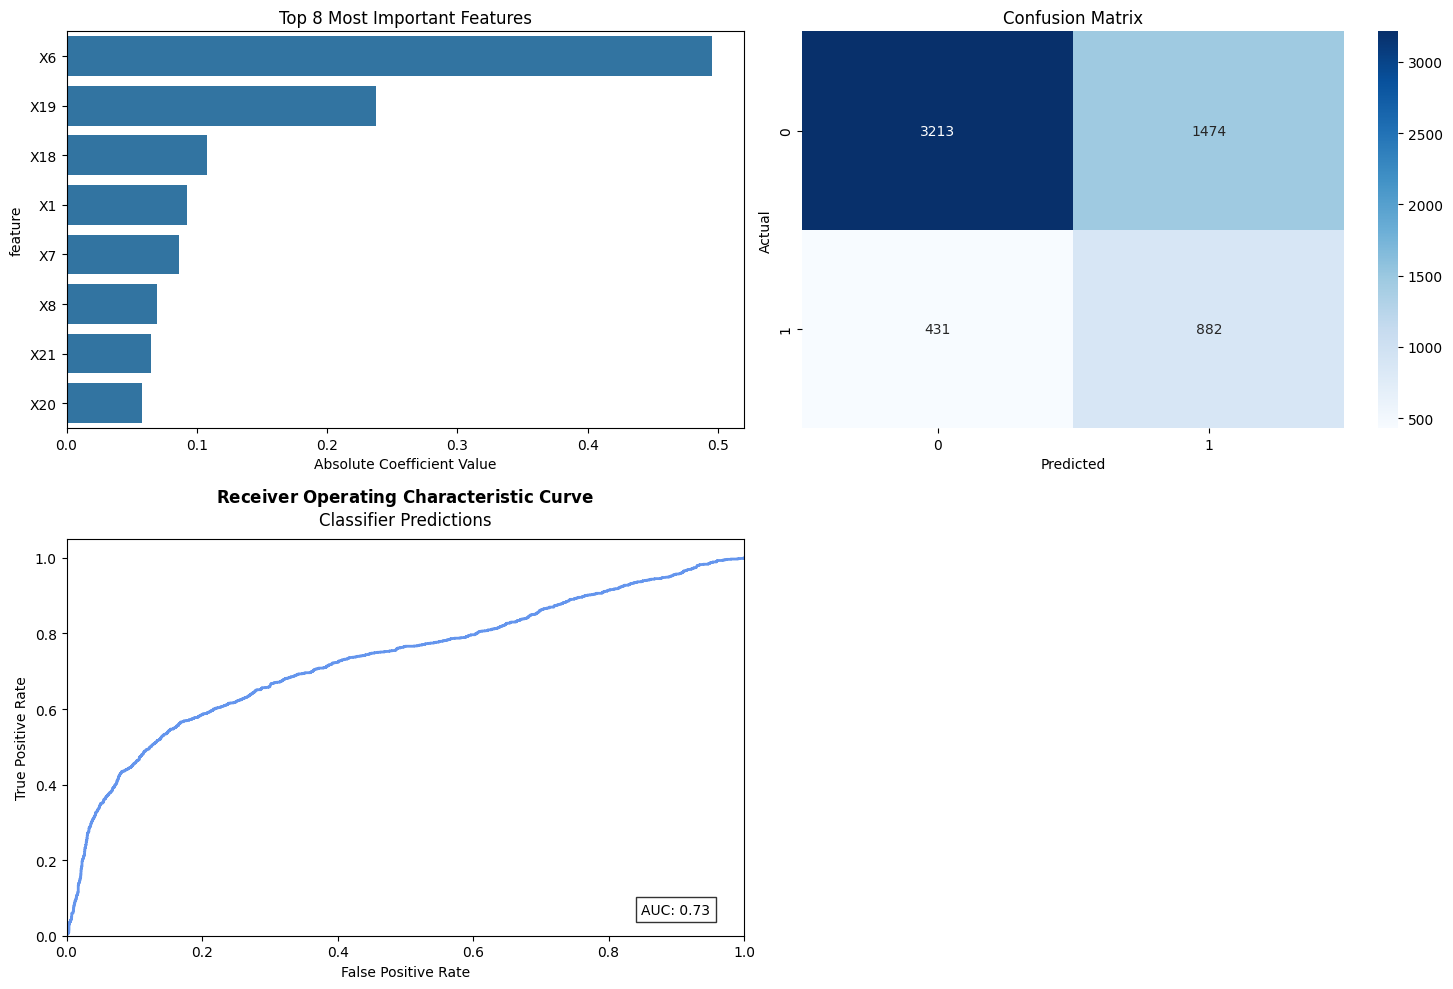

In [29]:
# Plotting
plt.figure(figsize=(15, 10))

# Feature Importance Plot
plt.subplot(2, 2, 1)
sns.barplot(data=importance_df.head(8),
            x='abs_importance',
            y='feature')
plt.title("Top 8 Most Important Features")
plt.xlabel('Absolute Coefficient Value')

# Confusion Matrix Plot
plt.subplot(2, 2, 2)
sns.heatmap(confusion_matrix(y2, y_pred),
            annot=True,
            fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve
plt.subplot(2, 2, 3)
fpr, tpr, _ = roc_curve(y2, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(r'$\mathbf{Receiver\ Operating\ Characteristic\ Curve}$'  # Main title (bold)
          '\nClassifier Predictions',                                # Subtitle (regular font)
          fontsize=12, loc='center', pad=10)      # Title and subtitle propertiesplt.legend(loc="lower right")
plt.text(0.95, 0.05, f'AUC: {roc_auc:.2f}', ha='right', va='bottom',
         bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

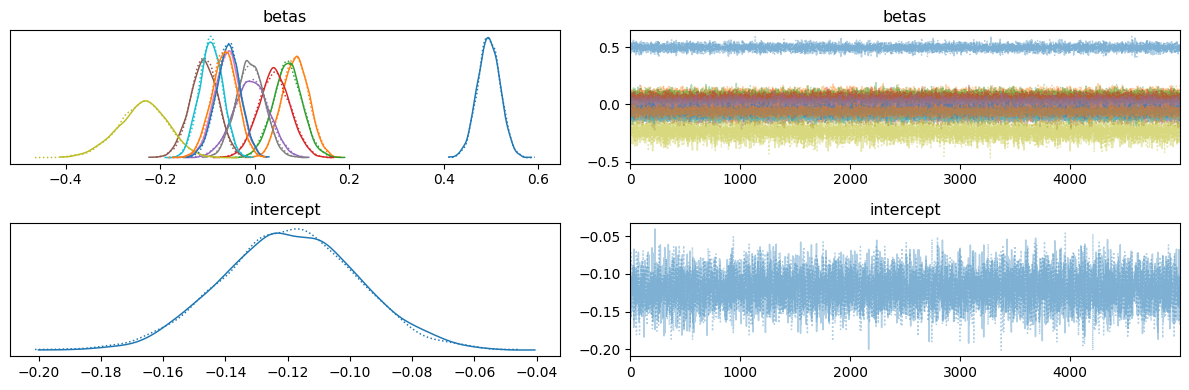

In [28]:
# MCMC Diagnostics Plot
plt.figure(figsize=(15, 10))
az.plot_trace(weighted_trace)
plt.tight_layout()
plt.show()